# Intelligente systemer: Recurrent Neural Networks (RNN)
Welcome to this notebook which is part of Kristiania University College's course «Utvikling og anvendelse av intelligente systemer», module 5, «Dyp læring og overføringslæring».

## How to use this notebook
This is a Jupyter notebook with text and Python code that you run by pressing shift-enter. The purpose is to become familiar with relevant concepts in practice, not necessarily to understand all the details of the code. Take the time to read the text, review the code, run the code cells (make sure they are in the correct order), study the results, and think about what we do, why and how.

In this notebook, you will find self-test questions in _italics_. Go to Canvas and answer the questions there before continuing with the notebook.

## The problem: Movie review sentiment analysis
The task is to perform sentiment analysis on movie reviews, determining if they are positive or negative.

## Dataset information
We will use a famous dataset for sentiment analysis, called the IMDb Large Movie Review Dataset. It is a dataset for binary sentiment classification containing 25,000 highly polarized movie reviews for training, and 25,000 for testing. 

![IMDb](figures/imdb.png)

## 1. Importing Libraries

In [1]:
#Importing libraries
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM

## 2. Loading the dataset from Keras

In [2]:
# Note: There is a bug on some systems that may affect this notebook.
# If you get a «Kernel Restarting» error message when running this notebook,
# uncomment the code below (i.e. remove the hash signs in the beginning of the
# code lines). Then restart the kernel and rerun the entire notebook from here.

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The IMDb dataset has been preprocessed. Each review has the format of an **indexed bag of words**, which means that, instead of plain text, it is stored as a list of IDs of its most frequent words. The ID-word correspondence are stored in a separate dictionary. The most frequent words come first and rare words are ignored.

Let's take a look at this format.

In [3]:
#Loading indexed reviews
vocabulary_size = 5000

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(input_train), len(input_test)))

Loaded dataset with 25000 training samples, 25000 test samples


In [4]:
#Loading the word:id dictionary and reversing it to id:word
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

In [5]:
len(id2word.values())

88584

In [6]:
input_train.shape

(25000,)

In [7]:
y_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [8]:
y_train[0]

1

In [9]:
#Example of an input sample (bag of words) and its label
decoded_bag = [id2word.get(i, ' ') for i in input_train[0]]
print('---review with words---')
print(decoded_bag)

print('\n---label---')
print(y_train[6])

---review with words---
['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'and', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', '

We have mapped the review to the original words and also revealed its label. We see that the label is 1, which means that it is a positive review.

_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 1 (vist nedenfor) i Canvas._

1. _What do you think are the advantages of using an indexed bag of words? Can you think of any disadvantages?_

## 3. Adding a pad sequence
In order to feed this data into our RNN, all input documents must have the same length. We can see the range of the length reviews:

In [10]:
all_reviews = np.concatenate([input_train, input_test])

In [11]:
lengths = [len(i) for i in all_reviews]
print('Minimum review length: {}'.format(min(lengths)))
print('Maximum review length: {}'.format(max(lengths)))

Minimum review length: 7
Maximum review length: 2494


_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 2 (vist nedenfor) i Canvas._

2. _Using what you have learned in previous exercises, can you plot the distribution of the input lengths? How would you describe the distribution?_

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#create new df 
df = pd.DataFrame({'length':lengths})

In [14]:
df.value_counts()

length
125       378
130       370
132       367
128       356
131       346
         ... 
1057        1
1061        1
1063        1
1078        1
2494        1
Length: 1060, dtype: int64

In [15]:
# Noen hjelpefunksjoner. Du må kjøre disse cellene.
def make_histogram(data, variable, binwidth, lower_lim=None, upper_lim=None):
    if upper_lim == None:
        upper_lim = data[variable].max()
    if lower_lim == None:
        lower_lim = data[variable].min()
    bins=np.arange(lower_lim, upper_lim + binwidth, binwidth)
    plt.hist(data[variable],bins=bins,edgecolor = 'black',alpha=0.75,range = [data[variable].min(),upper_lim])
    plt.ylabel("antall")
    plt.xlabel(variable)

(array([3.5259e+04, 1.0799e+04, 2.7610e+03, 1.0160e+03, 1.4500e+02,
        8.0000e+00, 6.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([   7. ,  255.7,  504.4,  753.1, 1001.8, 1250.5, 1499.2, 1747.9,
        1996.6, 2245.3, 2494. ]),
 <BarContainer object of 10 artists>)

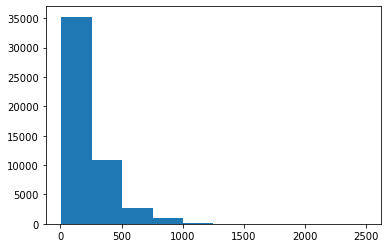

In [16]:
plt.hist(df)

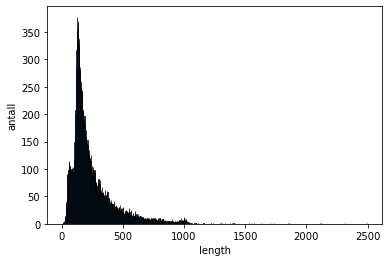

In [53]:
make_histogram(df, "length", 1)

In [17]:
df.describe()

,length
count,50000.000000
mean,234.758920
std,172.913224
min,7.000000
25%,129.000000
50%,176.000000
75%,285.000000
max,2494.000000


We will limit the maximum review length to `max_words` by truncating longer reviews and padding shorter reviews with a null value (0).

In [18]:
from tensorflow.keras.preprocessing import sequence
max_words = 500
input_train = sequence.pad_sequences(input_train, maxlen=max_words)
input_test = sequence.pad_sequences(input_test, maxlen=max_words)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [19]:
print('---review with words---')
print([id2word.get(i, ' ') for i in input_train[6]])
print('---label---')
print(y_train[6])

---review with words---
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 

We can check the lengths again to see that they all have the same lengths.

In [20]:
all_reviews = np.concatenate([input_train, input_test])
lengths = [len(i) for i in all_reviews]
print('Minimum review length: {}'.format(min(lengths)))
print('Maximum review length: {}'.format(max(lengths)))

Minimum review length: 500
Maximum review length: 500


_Oppgave: Svar på «Vi spør – du svarer»-spørsmålene 3 og 4 (vist nedenfor) i Canvas._

3. _What are the disadvantages of adjusting the samples’ lengths?_
4. _What are the advantages of such an approach? (Tip: Think about the bias-variance trade-off.)_

## 4. Defining the model using Keras

Next, we define the layers of the neural network. One of the layers we will use, is a Keras `SimpleRNN` layer.

In [21]:
max_features = 10000
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 5 (vist nedenfor) i Canvas._

5. _Can you explain why we used a sigmoid function as the activation function in the output layer?_

Let us display the architecture of the network so far:

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


## 5. Compiling and fitting the model on the training data
We will now train the Recurrent Neural Network on the IMDB review data.

During the next step of compiling the model, we specify the following:
1. `optimizer='rmsprop'` – specifies that we want to use rmsprop optimization during training. 
2. `loss=categorical_crossentropy` – the loss function we want to use in this case is the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) used in categorical classification. 
3. `metrics=['acc']` – sets which metrics to track during training.

In [23]:
#Compiling Model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['acc'])

Now, let's train the model by calling `.fit()`. All we need to pass is train_images and associated labels, the number of iterations (epochs) and the batch size. These are defined as:

- **Epochs**: The number of times the weights in the network will be updated. The value should be large enough for the network to converge (minimize loss to a stable level). If you run the training again without redefining the network, the training will continue from the previous session.

- **Batch size**: Determines the number of samples for cross-validation. Generally you should use as small a batch size as patience/available computing time allows for.

In [24]:
#Fitting Model
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 51s 303ms/step - loss: 0.6401 - acc: 0.6184 - val_loss: 0.4770 - val_acc: 0.7926
Epoch 2/10
157/157 [==============================] - 46s 293ms/step - loss: 0.4165 - acc: 0.8202 - val_loss: 0.3899 - val_acc: 0.8374
Epoch 3/10
157/157 [==============================] - 47s 301ms/step - loss: 0.3225 - acc: 0.8679 - val_loss: 0.4296 - val_acc: 0.8220
Epoch 4/10
157/157 [==============================] - 47s 300ms/step - loss: 0.2582 - acc: 0.8976 - val_loss: 0.3763 - val_acc: 0.8610
Epoch 5/10
157/157 [==============================] - 33s 211ms/step - loss: 0.1997 - acc: 0.9245 - val_loss: 0.4979 - val_acc: 0.8184
Epoch 6/10
157/157 [==============================] - 33s 211ms/step - loss: 0.1464 - acc: 0.9483 - val_loss: 0.4189 - val_acc: 0.8560
Epoch 7/10
157/157 [==============================] - 33s 209ms/step - loss: 0.1073 - acc: 0.9640 - val_loss: 0.4680 - val_acc: 0.8218
Epoch 8/10
157/157 [==============================] - 3

## 6. Evaluating the model performance on the validation data

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

print(f'Avearage Validation Loss:{np.round(np.mean(val_loss), 2)}\n Average Validation Accuracy:{np.round(np.mean(val_acc),2)}')

Avearage Validation Loss:0.48
 Average Validation Accuracy:0.82


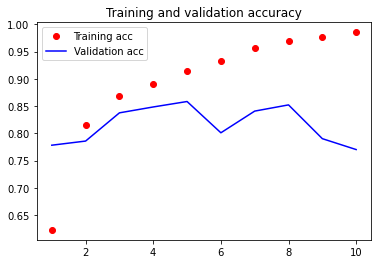

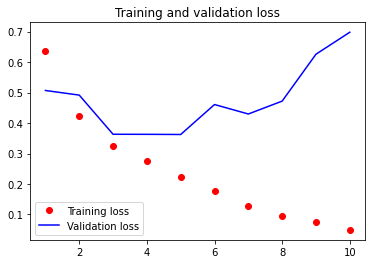

In [62]:
# plotting the training and validation accuracy
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

> Did you get a «Kernel Restarting» error message here? If so, go to the first code cell of this notebook, uncomment the code, restart the kernel, and try again. If that doesn't work, contact your supervisor.

This small recurrent neural network achieves the average validation accuracy of around 80 %. Let’s look at some more advanced layers and see if they can perform better.

## Long Short Term Memory

## 1. Defining the model using Keras

In [63]:
# Define Model
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

Let us display the architecture of the network so far:

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


## 2. Compiling and fitting the model on the training data
We will now train the LSTM on the IMDB review data.

In [65]:
# Compile Model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Now, let's train the model by calling `.fit()`. All we need to pass is train_images and associated labels, the number of iterations (epochs) and the batch size.

In [66]:
# Fit Model
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 65s 390ms/step - loss: 0.4963 - acc: 0.7665 - val_loss: 1.3955 - val_acc: 0.5166
Epoch 2/10
157/157 [==============================] - 59s 374ms/step - loss: 0.3224 - acc: 0.8691 - val_loss: 0.3508 - val_acc: 0.8500
Epoch 3/10
157/157 [==============================] - 65s 414ms/step - loss: 0.2649 - acc: 0.8975 - val_loss: 0.3366 - val_acc: 0.8518
Epoch 4/10
157/157 [==============================] - 66s 423ms/step - loss: 0.2409 - acc: 0.9083 - val_loss: 0.3598 - val_acc: 0.8440
Epoch 5/10
157/157 [==============================] - 64s 405ms/step - loss: 0.2200 - acc: 0.9172 - val_loss: 0.2867 - val_acc: 0.8792
Epoch 6/10
157/157 [==============================] - 62s 397ms/step - loss: 0.2078 - acc: 0.9233 - val_loss: 0.3473 - val_acc: 0.8470
Epoch 7/10
157/157 [==============================] - 66s 418ms/step - loss: 0.1955 - acc: 0.9265 - val_loss: 0.3140 - val_acc: 0.8804
Epoch 8/10
157/157 [==============================] - 6

## 3. Evaluating the model performance on the validation data

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

print(f'Average Validation Loss:{np.round(np.mean(val_loss), 2)}\nAverage Validation Accuracy:{np.round(np.mean(val_acc),2)}')

Average Validation Loss:0.45
Average Validation Accuracy:0.82


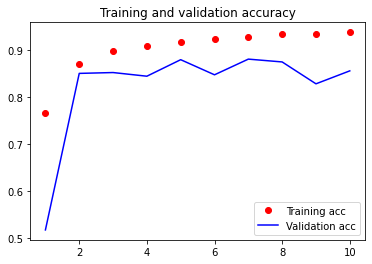

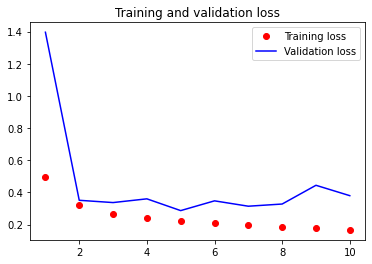

In [68]:
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This time, we achieved up to 89 % validation accuracy. Not bad: certainly much better than the SimpleRNN network. We can further increase the accuracy by tuning hyperparameters such as dimensionality of embeddings or the LSTM output.

_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 6 (vist nedenfor) i Canvas._

6. _Can you think of a possible explanation of why LSTM works better than SimpleRNN for this data?_